Logging into HF hub

In [2]:
import os

from dotenv import load_dotenv
from huggingface_hub import login

# Load environment variables from .env file
load_dotenv()

# Access the Hugging Face Hub API token
huggingfacehub_api_token = os.getenv('HUGGINGFACEHUB_API_TOKEN')

# Log in to the Hugging Face Hub
login(token=huggingfacehub_api_token)

Loading tech4humans signature dataset

In [3]:
from datasets import load_dataset

# Load the tech4humans signature dataset
dataset = load_dataset("samuellimabraz/signature-detection")

# Print the dataset to verify it has been loaded correctly
print(dataset["train"][0])

{'image_id': 1825, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x21FD4116900>, 'width': 640, 'height': 640, 'objects': {'id': [2134, 2135, 2136, 2137], 'area': [5081, 1064, 4626, 1503], 'bbox': [[198.0, 55.0, 43.060001373291016, 118.0], [263.0, 195.0, 24.750999450683594, 43.0], [518.0, 37.0, 46.72800064086914, 99.0], [587.0, 157.0, 28.908000946044922, 52.0]], 'category': [0, 0, 0, 0]}}


Loading pre-trained model

In [4]:
from transformers import YolosImageProcessor, YolosForObjectDetection

CKPT_PATH = "hustvl/yolos-small"
IMG_SIZE = 640
TARGET = "signature"
ID2LABEL = {0: TARGET}
LABEL2ID = {TARGET: 0}

processor = YolosImageProcessor.from_pretrained(CKPT_PATH, do_resize=True, size={"width": IMG_SIZE, "height": IMG_SIZE})
model = YolosForObjectDetection.from_pretrained(CKPT_PATH, num_labels=len(ID2LABEL), id2label=ID2LABEL, label2id=LABEL2ID, ignore_mismatched_sizes=True, device_map="auto")

c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\accelerate\utils\modeling.py:808: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  _ = torch.tensor([0], device=i)
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([2, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Converting data into COCO format

In [5]:
from utils.dataset import SignatureDataset

train_dataset = SignatureDataset(dataset["train"], processor)
val_dataset = SignatureDataset(dataset["validation"], processor)
test_dataset = SignatureDataset(dataset["test"], processor)

In [6]:
from torch.utils.data import DataLoader
from utils.dataset import get_collate_fn

collate_fn = get_collate_fn(processor)

BATCH_SIZE = 1

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE)
batch = next(iter(train_dataloader))

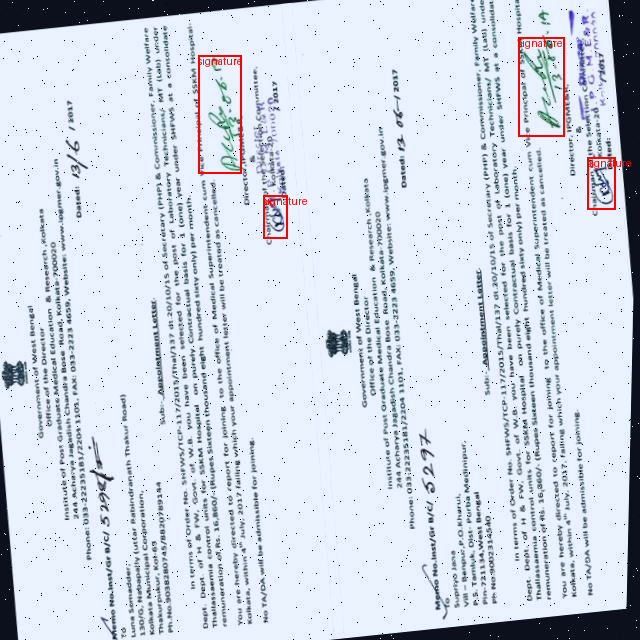

In [32]:
from utils.visualizer import visualize_item

visualize_item(train_dataset[0])

Fine-tuning the model

In [ ]:
from utils.model import YolosForSignatureDetection

pl_model = YolosForSignatureDetection(lr=2.5e-5, weight_decay=1e-4, model=model)

# outputs = pl_model(pixel_values=batch["pixel_values"].to(model.device))
# outputs.logits.shape

In [9]:
from pytorch_lightning import Trainer

trainer = Trainer(max_steps=2000, gradient_clip_val=0.1, accumulate_grad_batches=4)
trainer.fit(pl_model)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `n

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined